In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, Reshape
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import callbacks
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями

import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import math
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
from google.colab import drive
import datetime

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_zip   = '/content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Datasets/animals-v1.zip'
dataset = '/content/animals-v1'

In [ ]:
!rm -rf {dataset}

In [ ]:
!unzip -q {dataset_zip} -d {'/content/'}

In [ ]:
# словарь с таблицами вероятностей
labels = {}
labels['pecora']       = [1,0,0]
labels['ragno']         = [0,1,0]
labels['scoiattolo']     = [0,0,1]

# список для удобного обращения к названию по индексу
labels_list = ["pecora", "ragno", "scoiattolo"]

In [ ]:
def smart_trimming(img):
  img_w, img_h = img.size   # Берём размер картинки
  target_size = [120, 120]  # Размер, который мы должны получить в результате

  # Проверка на формат
  if img_w > img_h:
    new_h = target_size[1]                # Высота - основная ось
    new_w = round(new_h / img_h * img_w)  # Вычисление ширины
  else:
    new_w = target_size[0]                # Ширина - основная ось
    new_h = round(new_w / img_w * img_h)  # Вычисление высоты

  # Изменения касательно размеров
  img = img.resize((new_w, new_h), Image.ANTIALIAS)

  # Поиск центра картинки
  center = [new_w//2, new_h//2]

  # Поиск координат для прямоугольной обрезки
  top_left = [center[0] - target_size[0]//2, center[1] - target_size[1]//2]
  bottom_right = [center[0] + target_size[0]//2, center[1] + target_size[1]//2]

  # Обрезка изображения
  img = img.crop((top_left[0], top_left[1], bottom_right[0], bottom_right[1]))

  return img

In [ ]:
# списки с путями к картинкам
image_list = []
test_image_list = []

In [ ]:
# проход по папкам с изображениями
for label in labels.keys():
  dir = dataset +"/" + label
  flist = os.listdir(dataset + "/" + label)
  img_for_test = 0
  for f in flist:
    # Заполнение списка путей тестовой выборки
    if img_for_test < 2:
      fpath = dataset+ "/" + label + "/" + f
      test_image_list.append(fpath)
      
      img_for_test += 1
    # Заполнение списка путей обучающщей выборки
    else:
      fpath = dataset+ "/" + label + "/" + f
      image_list.append(fpath)

In [ ]:
# перемешивание списков, чтобы учить н.с. на изображениях в случайном порядке
random.shuffle(image_list)
random.shuffle(test_image_list)

# Списки для выборок
x_train = []
y_train = []

x_test = []
y_test = []

In [ ]:
# Заполнение тестовых выборок
for fpath in test_image_list:
  img = Image.open(fpath)
  img = smart_trimming(img) # Приведение к единому формату

  img = np.array(img)

  # Проверка, на случай, если функция умной обрезки несработала и не выдала ошибку
  if img.shape == (120, 120, 3):
    x_test.append(img)

    label = fpath.split('/')[3] # Получение верного ответа из пути
    y_test.append(labels[label])

In [ ]:
# Заполнение обучающей выборки
for fpath in image_list:
  img = Image.open(fpath)
  img = smart_trimming(img) # Приведение к единому формату

  img = np.array(img)

  # Проверка, на случай, если функция умной обрезки несработала и не выдала ошибку
  if img.shape == (120, 120, 3):
    x_train.append(img)

    label = fpath.split('/')[3] # Получение верного ответа из пути
    y_train.append(labels[label])

In [ ]:
# Вывод размерностей выборок для проверки и определения, сколько от них забрать для проверочной выборки
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

8496 8496
6 6


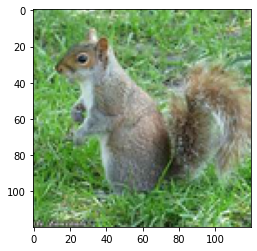

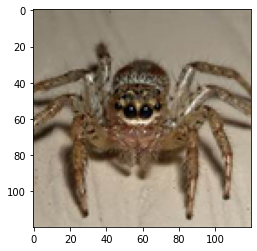

In [ ]:
# проверка картинок в списках
plt.imshow(x_train[74])
plt.show()

plt.imshow(x_test[3])
plt.show()

In [ ]:
# проверка размерностей картинок в списках
print(x_train[74].shape)
print(x_test[3].shape)

(120, 120, 3)
(120, 120, 3)


In [ ]:
# Перевод списков в np.array Этот формат массивов необх. для обучения н.с.

x_train = np.array(x_train, dtype='uint8')
y_train = np.array(y_train, dtype='uint8')

In [ ]:
# Создание валидационной выборки

x_val = x_train[7600:]
y_val = y_train[7600:]

x_train = x_train[:7600]
y_train = y_train[:7600]

x_test = np.array(x_test)
y_test = np.array(y_test)

# проверяем размер x_val
print(x_val.shape)
print(y_val.shape)

(896, 120, 120, 3)
(896, 3)


In [ ]:
# Моя функциональная н.с.
img_input = Input((120, 120, 3))

# b = branch
# b_part = branch_part

# Первая ветка # Содержит подветки со своими особенностями
b1 = Conv2D(64, (3, 3), padding='same')(img_input)
b1 = BatchNormalization()(b1)
b1 = Activation('relu')(b1)
b1 = Dropout(0.2)(b1)
b1 = MaxPooling2D()(b1)

# Разделение ветки на 2

# Постепенное увеличение кол. формируемых признаков. Делаем их окном свёртки (3,3)
b1_part1 = Conv2D(128, (3, 3), padding='same')(b1) # 128 - Увеличели кол. формируемых признаков
b1_part1 = BatchNormalization()(b1_part1)
b1_part1 = Activation('relu')(b1_part1)
b1_part1 = Dropout(0.2)(b1_part1)
b1_part1 = MaxPooling2D()(b1_part1)

b1_part1 = Conv2D(256, (3, 3), padding='same')(b1_part1) # 256 - Увеличели кол. формируемых признаков
b1_part1 = BatchNormalization()(b1_part1)
b1_part1 = Activation('relu')(b1_part1)
b1_part1 = Dropout(0.2)(b1_part1)
b1_part1 = MaxPooling2D()(b1_part1)

# Постепенное увеличение кол. формируемых признаков. Делаем их окном свёртки (6,6)
b1_part2 = Conv2D(128, (6, 6), padding='same')(b1)
b1_part2 = BatchNormalization()(b1_part2)
b1_part2 = Activation('relu')(b1_part2)
b1_part2 = Dropout(0.2)(b1_part2)
b1_part2 = MaxPooling2D()(b1_part2)

b1_part2 = Conv2D(256, (6, 6), padding='same')(b1_part2)
b1_part2 = BatchNormalization()(b1_part2)
b1_part2 = Activation('relu')(b1_part2)
b1_part2 = Dropout(0.2)(b1_part2)
b1_part2 = MaxPooling2D()(b1_part2)

# Вторая ветка # Простое наращивание кол. формируемых признаков.
b2 = Conv2D(64, (3, 3), padding='same', activation='relu')(img_input)
b2 = BatchNormalization()(b2)
b2 = Dropout(0.2)(b2)
b2 = MaxPooling2D()(b2)

b2 = Conv2D(128, (3, 3), padding='same', activation='relu')(b2) # 128 - Увеличели кол. формируемых признаков
b2 = BatchNormalization()(b2)
b2 = Dropout(0.2)(b2)
b2 = MaxPooling2D()(b2)

b2 = Conv2D(256, (3, 3), padding='same', activation='relu')(b2) # 256 - Увеличели кол. формируемых признаков
b2 = BatchNormalization()(b2)
b2 = Dropout(0.2)(b2)
b2 = MaxPooling2D()(b2)

# Соединяем сразу все ветки.
# Кол. формируемых в их последних слоях признаков должно быть одинаковым. В этом случае оно = 256
branch_united = concatenate([b1_part2, b1_part1, b2]) 

# Ещё несколько операций с полученной веткой

branch_united = Conv2D(256, (4, 4), padding='same')(branch_united)
branch_united = Flatten()(branch_united)
branch_united = Dense(3, activation='softmax')(branch_united)

functional_network_model = Model(img_input, branch_united)

In [ ]:
# Описание модели
functional_network_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 120, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 120, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

Epoch 1/10
760/760 [==============================] - 53s 56ms/step - loss: 429.2271 - accuracy: 0.6163 - val_loss: 14.4536 - val_accuracy: 0.6953
Epoch 2/10
760/760 [==============================] - 42s 55ms/step - loss: 5.2195 - accuracy: 0.6876 - val_loss: 4.8700 - val_accuracy: 0.7232
Epoch 3/10
760/760 [==============================] - 42s 55ms/step - loss: 1.5777 - accuracy: 0.7333 - val_loss: 0.9771 - val_accuracy: 0.7634
Epoch 4/10
760/760 [==============================] - 42s 55ms/step - loss: 1.0277 - accuracy: 0.7545 - val_loss: 0.9103 - val_accuracy: 0.7254
Epoch 5/10
760/760 [==============================] - 41s 55ms/step - loss: 0.6357 - accuracy: 0.7900 - val_loss: 0.6927 - val_accuracy: 0.7701
Epoch 6/10
760/760 [==============================] - 42s 55ms/step - loss: 0.7531 - accuracy: 0.7663 - val_loss: 0.8626 - val_accuracy: 0.7422
Epoch 7/10
760/760 [==============================] - 42s 55ms/step - loss: 0.7205 - accuracy: 0.7662 - val_loss: 1.5350 - val_accura

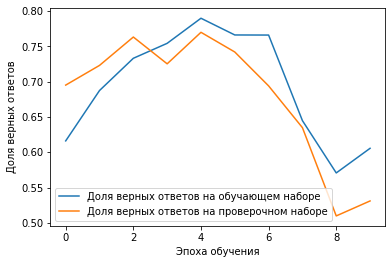

In [ ]:
functional_network_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

# Обучение сети
batch_size = 10
history = functional_network_model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=10,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Отображение графика
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/5
760/760 [==============================] - 44s 55ms/step - loss: 3.5274 - accuracy: 0.6876 - val_loss: 224.3467 - val_accuracy: 0.5848
Epoch 2/5
760/760 [==============================] - 42s 55ms/step - loss: 1.0965 - accuracy: 0.6917 - val_loss: 1937.0099 - val_accuracy: 0.6105
Epoch 3/5
760/760 [==============================] - 42s 55ms/step - loss: 1.1032 - accuracy: 0.6968 - val_loss: 20313.7344 - val_accuracy: 0.4665
Epoch 4/5
760/760 [==============================] - 42s 55ms/step - loss: 0.8542 - accuracy: 0.7180 - val_loss: 13294.2285 - val_accuracy: 0.6295
Epoch 5/5
760/760 [==============================] - 42s 55ms/step - loss: 0.9056 - accuracy: 0.7220 - val_loss: 120.2980 - val_accuracy: 0.6842


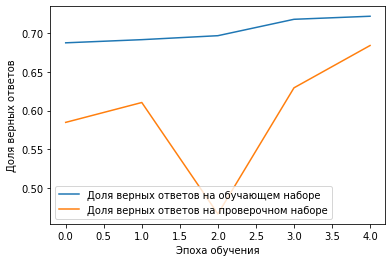

In [ ]:
# Уменьшенный шаг обучения
functional_network_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# Обучение сети
batch_size = 10
history = functional_network_model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=5,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Отображение графика
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

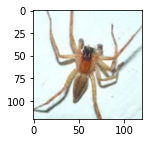

Выход сети:
[0.00635794 0.78644305 0.20719905]

0 -> 0.0063579431734979152679443359375000000000
1 -> 0.7864430546760559082031250000000000000000
2 -> 0.2071990519762039184570312500000000000000

Распознан объект:  1 - ragno
Верный ответ:  1 - ragno


In [ ]:
prediction = functional_network_model.predict(x_test)

n = 0

img = x_test[n]
img = img.reshape(120, 120, 3)
img = img.astype('uint8')
plt.figure(figsize=(2, 2))
plt.imshow(Image.fromarray(img)) #Отображаем изображение i-ым графиков
plt.show()

print("Выход сети:")
print(prediction[n])
print()
for i in range(3):
  print(i,"->","{:.40f}".format(prediction[n][i]))
print()
# print(labels[np.argmax(prediction[n])])
print("Распознан объект: ", np.argmax(prediction[n]), "-", labels_list[np.argmax(prediction[n])])
print("Верный ответ: ", np.argmax(y_test[n]), "-", labels_list[np.argmax(y_test[n])])